## 1 Autoencoder
A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of Dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.
Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.
An example to guide your thinking can be found toward the bottom of this post https://blog.keras.io/building-autoencoders-in-keras.html. DO NOT JUST COPY THIS CODE AND TURN IT IN. BE CREATIVE, COME UP WITH YOUR OWN VARIATION.
After training your network, visualize some examples of input images and their decoded reconstruction.


In [232]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Input, Embedding, LSTM

from keras.models import Model,Sequential
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from tqdm import tqdm

##### Load data

In [243]:
# load data from keras
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)

# normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print (x_train.shape)
print (x_test.shape)

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


##### Set Up Model Structure

In [46]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # 28*28*16
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)        
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)           # 14*14*8
x = MaxPooling2D((2, 2), padding='same')(x)                           # 7*7*8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)           # 7*7*8
encoded = MaxPooling2D((2, 2), padding='same')(x)                     # 4*4*8

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu',padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [47]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 28, 28, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 8)           0  

##### Run Model

In [48]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_590')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 125s 2ms/step - loss: 0.3732 - val_loss: 0.3193
Epoch 2/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.3135 - val_loss: 0.3059
Epoch 3/100
60000/60000 [==============================] - 119s 2ms/step - loss: 0.3028 - val_loss: 0.3006
Epoch 4/100
60000/60000 [==============================] - 118s 2ms/step - loss: 0.2970 - val_loss: 0.3020
Epoch 5/100
60000/60000 [==============================] - 119s 2ms/step - loss: 0.2927 - val_loss: 0.2878
Epoch 6/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.2892 - val_loss: 0.2910
Epoch 7/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.2862 - val_loss: 0.2876
Epoch 8/100
60000/60000 [==============================] - 119s 2ms/step - loss: 0.2840 - val_loss: 0.2832
Epoch 9/100
60000/60000 [==============================] - 117s 2ms/step - loss: 0.2819 - val_

##### Visualize Result

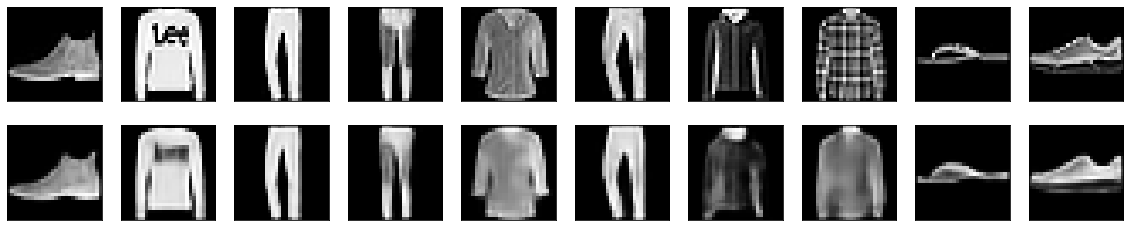

In [49]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classification
We’ll continue to use the Fashion MNIST dataset and build a deep convolutional network for classification.


#### 2.1 Deep CNN
Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.

In [252]:
# load data from keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)

# normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print (x_train.shape)
print (x_test.shape)

print (y_train.shape)
print (y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                            test_size = 0.2, random_state = 42)

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [268]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # 28*28*16
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)        
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)           # 14*14*8
x = MaxPooling2D((2, 2), padding='same')(x)                           # 7*7*8
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)           # 7*7*8
x = MaxPooling2D((2, 2), padding='same')(x)                           # 4*4*8
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(150,activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_image_CNN = Model(input_img, output)
model_image_CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
model_image_CNN.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 8)         1160      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 7, 7, 8)           0  

Brief description of the architectural:
In this CNN model, I used 4 convolutional layers, two maxpooling, one dropout layer and two dense layers, details see summary above.

In [270]:
hist_image_CNN = model_image_CNN.fit(x_train, y_train,
                                batch_size=64,
                                epochs=50,
                                verbose=1,
                                validation_data=(x_val,y_val),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0001)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 81s 2ms/step - loss: 0.6153 - accuracy: 0.7752 - val_loss: 0.3970 - val_accuracy: 0.8565
Epoch 2/50
48000/48000 [==============================] - 97s 2ms/step - loss: 0.4241 - accuracy: 0.8433 - val_loss: 0.3381 - val_accuracy: 0.8737
Epoch 3/50
48000/48000 [==============================] - 88s 2ms/step - loss: 0.3704 - accuracy: 0.8633 - val_loss: 0.3023 - val_accuracy: 0.8894
Epoch 4/50
48000/48000 [==============================] - 94s 2ms/step - loss: 0.3412 - accuracy: 0.8716 - val_loss: 0.2827 - val_accuracy: 0.8942
Epoch 5/50
48000/48000 [==============================] - 105s 2ms/step - loss: 0.3166 - accuracy: 0.8830 - val_loss: 0.2718 - val_accuracy: 0.8975
Epoch 6/50
48000/48000 [==============================] - 91s 2ms/step - loss: 0.3011 - accuracy: 0.8888 - val_loss: 0.2674 - val_accuracy: 0.9007
Epoch 7/50
48000/48000 [==============================] - 83s 2ms/s

In [274]:
# overall score
accr_train = model_image_CNN.evaluate(x_train, y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_train[0],accr_train[1]))

accr_test = model_image_CNN.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_test[0],accr_test[1]))


48000/48000 [==============================] - 14s 299us/step
Train set
  Loss: 0.113
  Accuracy: 0.961
10000/10000 [==============================] - 4s 389us/step
Test set
  Loss: 0.217
  Accuracy: 0.926


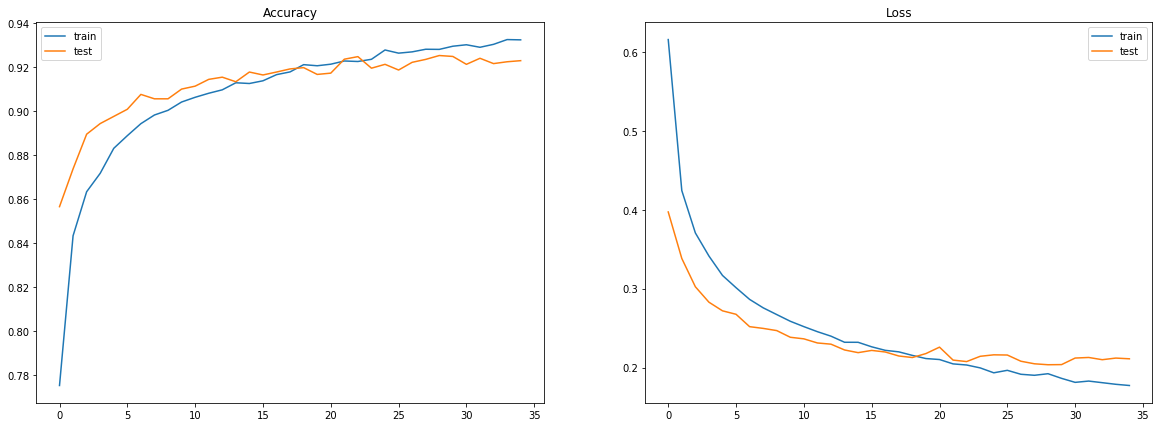

In [272]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(20,7))

ax1.set_title('Accuracy')
ax1.plot(hist_image_CNN.history['accuracy'], label='train')
ax1.plot(hist_image_CNN.history['val_accuracy'], label='test')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(hist_image_CNN.history['loss'], label='train')
ax2.plot(hist_image_CNN.history['val_loss'], label='test')
ax2.legend()

#### 2.2 Transfer Learning
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.


In [353]:
# load data from keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)


###### resize image data as ResNet50 requires minimum image size is 32*32

Text(0.5, 1.0, 'After (32*32)')

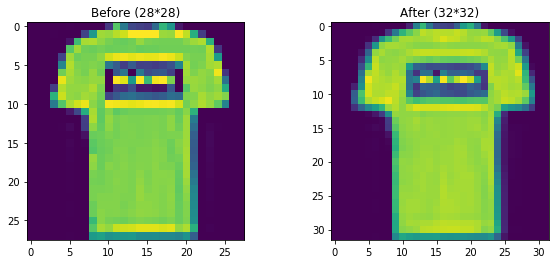

In [354]:
# before resize
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(10,4))
ax1.imshow(x_train[1])
ax1.set_title('Before (28*28)')



###### resize image data as ResNet50 requires minimum image size is 32*32  #########
import cv2
x_train_new = []
for i in range(x_train.shape[0]):
    new = cv2.resize(x_train[i], (32,32))
    x_train_new.append(new)
x_train = np.asarray(x_train_new)

x_test_new = []
for i in range(x_test.shape[0]):
    new = cv2.resize(x_test[i], (32,32))
    x_test_new.append(new)
x_test = np.asarray(x_test_new)


###############################################


# after
ax2.imshow(x_train[1])
ax2.set_title('After (32*32)')

In [358]:
print("x_train shape:", x_train.shape, "x_test shape:", x_test.shape)

x_train shape: (48000, 32, 32, 3) x_test shape: (10000, 32, 32, 3)


In [356]:
# normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# duplicate image from 1 to 3 channels
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

# reshape
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))
  
print (x_train.shape)
print (x_test.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [357]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

###### set up ResNet50 structure

In [375]:
from keras import applications

model_ResNet50 = applications.ResNet50(weights='imagenet', include_top=False, input_shape=[32, 32, 3])

In [376]:
num_classes = 10

add_model = Sequential()
add_model.add(Flatten(input_shape=model_ResNet50.output_shape[1:]))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.4))
add_model.add(Dense(num_classes, activation='softmax'))


model_ResNet50 = Model(inputs=model_ResNet50.input, outputs=add_model(model_ResNet50.output))
model_ResNet50.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ResNet50.summary()


Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_54[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [377]:
hist_ResNet50 = model_ResNet50.fit(x_train, y_train,
                                batch_size=64,
                                epochs=50,
                                verbose=1,
                                validation_data=(x_val,y_val),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0001)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 2476s 52ms/step - loss: 0.5699 - accuracy: 0.8370 - val_loss: 1.1243 - val_accuracy: 0.6362
Epoch 2/50
48000/48000 [==============================] - 1942s 40ms/step - loss: 0.3086 - accuracy: 0.8935 - val_loss: 0.5273 - val_accuracy: 0.8391
Epoch 3/50
48000/48000 [==============================] - 3221s 67ms/step - loss: 0.3510 - accuracy: 0.8958 - val_loss: 0.4694 - val_accuracy: 0.8506
Epoch 4/50
48000/48000 [==============================] - 1874s 39ms/step - loss: 0.3797 - accuracy: 0.8803 - val_loss: 0.9498 - val_accuracy: 0.6982
Epoch 5/50
48000/48000 [==============================] - 1827s 38ms/step - loss: 0.3443 - accuracy: 0.8800 - val_loss: 0.2934 - val_accuracy: 0.8953
Epoch 6/50
48000/48000 [==============================] - 1829s 38ms/step - loss: 0.2843 - accuracy: 0.9014 - val_loss: 0.3427 - val_accuracy: 0.8768
Epoch 7/50
48000/48000 [==========================

In [378]:
# overall score
accr_train = model_ResNet50.evaluate(x_train, y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_train[0],accr_train[1]))

accr_test = model_ResNet50.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_test[0],accr_test[1]))

48000/48000 [==============================] - 132s 3ms/step
Train set
  Loss: 0.170
  Accuracy: 0.934
10000/10000 [==============================] - 27s 3ms/step
Test set
  Loss: 0.286
  Accuracy: 0.901


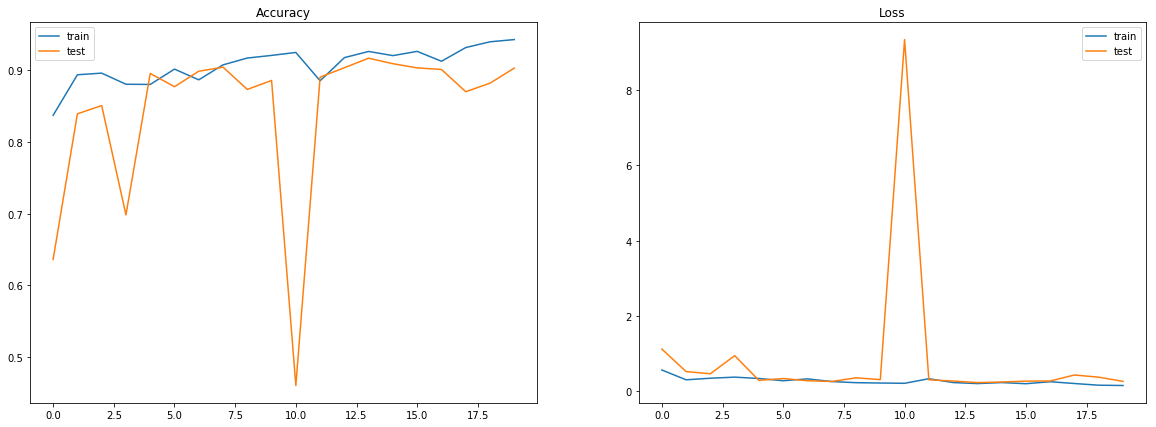

In [379]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(20,7))

ax1.set_title('Accuracy')
ax1.plot(hist_ResNet50.history['accuracy'], label='train')
ax1.plot(hist_ResNet50.history['val_accuracy'], label='test')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(hist_ResNet50.history['loss'], label='train')
ax2.plot(hist_ResNet50.history['val_loss'], label='test')
ax2.legend()

## 3 Text Classification
While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete sequences such as text. In this problem, we will tackle the task of text classification in the context of natural language.  
Background: In this problem, we will build models that read short text segments (tweets) and identify if one or more specific topics are being discussed.  
Dataset: The dataset consists of tweets along with labels for which topics were being referenced in the tweet. Examples of the topics include ”storms”, ”rain”, ”hurricane”, ”snow” and so on. Unlike previous classification problems we have encountered, in this dataset, there is not just a single right answer. The labels here are derived from multiple annotators decided how to label each tweet, so a single tweet can be about more than one topic. The label is the fraction of annotations for a given topic, and each row should sum to 1.  
What Loss function should you use here? Categorical CrossEntropy might work, but with some modification since we don’t have ”hard” labels over the categories. Another option might be sigmoid: for each output category, use a sigmoid to collapse the output to between 0 and 1, but each category output can be roughly independent of the others. In the problems below, feel free to try both.

##### load data

In [5]:
# create a label dictionary
Label_Dict = {
'k1':"clouds",
'k2':"cold",
'k3':"dry",
'k4':"hot",
'k5':"humid",
'k6':"hurricane",
'k7':"I can't tell",
'k8':"ice",
'k9':"other",
'k10':"rain",
'k11':"snow",
'k12':"storms",
'k13':"sun",
'k14':"tornado",
'k15':"wind"}

In [6]:
df = pd.read_csv('data/tweet/tweets_with_labels.csv', sep='\t')
df.shape

(77946, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77946 entries, 0 to 77945
Data columns (total 17 columns):
id       77946 non-null int64
tweet    77946 non-null object
k1       77946 non-null float64
k2       77946 non-null float64
k3       77946 non-null float64
k4       77946 non-null float64
k5       77946 non-null float64
k6       77946 non-null float64
k7       77946 non-null float64
k8       77946 non-null float64
k9       77946 non-null float64
k10      77946 non-null float64
k11      77946 non-null float64
k12      77946 non-null float64
k13      77946 non-null float64
k14      77946 non-null float64
k15      77946 non-null float64
dtypes: float64(15), int64(1), object(1)
memory usage: 10.1+ MB


In [8]:
df.head(50)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,1.000,0.0,0.000,0.000,0.000,0.000
1,2,RT: @mention: I love rainy days.,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,1.000,0.0,0.000,0.000,0.000,0.000
2,3,Good Morning Chicago! Time to kick the Windy C...,0.000,0.000,0.000,0.000,0.000,0.00,1.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.000,0.000,0.000,0.000,0.000,0.00,0.604,0.0,0.196,0.000,0.0,0.000,0.201,0.000,0.000
4,9,@mention good morning sunshine,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,0.0,0.000,1.000,0.000,0.000
5,10,Rather be storm chasing.,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,0.0,1.000,0.000,0.000,0.000
6,11,#WEATHER: 1:54 pm : 61.0F. Feels 60F. 29.98% ...,0.000,0.203,0.176,0.000,0.376,0.00,0.421,0.0,0.176,0.000,0.0,0.000,0.000,0.000,0.579
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0.000,0.000,0.000,1.000,0.000,0.00,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000
8,14,Mild Monday best weather day of the week in Ok...,0.000,0.000,0.000,0.194,0.000,0.00,0.605,0.0,0.200,0.000,0.0,0.000,0.000,0.000,0.000
9,15,"With the snow forecast for Tahoe this weekend,...",0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,0.000,0.000,1.0,0.000,0.000,0.000,0.000


In [9]:
df.iloc[70]['tweet']

'RT @mention: RT @mention a high of 56 degrees today. . .3 days ago the high was 91. #Bullshxt ---#brixx'

##### Clean Text

In [98]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [99]:
import re
def clean_text(text):
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # Removing extra spaces
    text = " ".join(text.split())
    # lower case
    
    return(text)

In [100]:
# The maximum number of words to be used. (most frequent)
max_num_words = 10000
# Max number of words in each tweet.
max_len_seq = 64
# This is fixed.
emb_dim = 64

In [101]:
# clean texts
cleantext = [clean_text(text) for text in df['tweet'].values]
cleantext = np.array(cleantext)

In [102]:
tokenizer = Tokenizer(num_words=max_num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleantext)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39713 unique tokens.


In [103]:
X = tokenizer.texts_to_sequences(cleantext)
X = sequence.pad_sequences(X, maxlen=max_len_seq)

Y = df.iloc[:,2:17]

print('Shape of data tensor:', X.shape)
print('Shape of data tensor:', Y.shape)

Shape of data tensor: (77946, 64)
Shape of data tensor: (77946, 15)


In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42) 
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(54562, 64) (54562, 15)
(23384, 64) (23384, 15)


#### 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).


###### set up RNN structure

In [179]:
# set up RNN structure
model_text_RNN = Sequential()
model_text_RNN.add(Embedding(max_num_words, emb_dim, input_length=X_train.shape[1]))
model_text_RNN.add(Dropout(0.4))
model_text_RNN.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model_text_RNN.add(Dense(15, activation='sigmoid'))
model_text_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_text_RNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 64, 200)           4000000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_22 (Dense)             (None, 15)                495       
Total params: 4,030,319
Trainable params: 4,030,319
Non-trainable params: 0
_________________________________________________________________


###### run model

In [180]:
epochs = 20
batch_size = 64

history = model_text_RNN.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 43649 samples, validate on 10913 samples
Epoch 1/20
43649/43649 [==============================] - 137s 3ms/step - loss: 1.9472 - accuracy: 0.5596 - val_loss: 1.3135 - val_accuracy: 0.7902
Epoch 2/20
43649/43649 [==============================] - 131s 3ms/step - loss: 1.2400 - accuracy: 0.8034 - val_loss: 1.1830 - val_accuracy: 0.8114
Epoch 3/20
43649/43649 [==============================] - 131s 3ms/step - loss: 1.1322 - accuracy: 0.8201 - val_loss: 1.1426 - val_accuracy: 0.8134
Epoch 4/20
43649/43649 [==============================] - 132s 3ms/step - loss: 1.0771 - accuracy: 0.8298 - val_loss: 1.1310 - val_accuracy: 0.8183
Epoch 5/20
43649/43649 [==============================] - 135s 3ms/step - loss: 1.0431 - accuracy: 0.8358 - val_loss: 1.1339 - val_accuracy: 0.8196
Epoch 6/20
43649/43649 [==============================] - 133s 3ms/step - loss: 1.0175 - accuracy: 0.8412 - val_loss: 1.1358 - val_accuracy: 0.8158
Epoch 7/20
43649/43649 [==============================] - 126s

In [181]:
accr = model_text_RNN.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23384/23384 [==============================] - 15s 626us/step
Test set
  Loss: 1.138
  Accuracy: 0.814


#### 3.2 CNN
Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). You might gain some insight and inspiration from these text classification approaches:  
• http://www.aclweb.org/anthology/D14-1181  
• https://arxiv.org/abs/1702.08568

###### Setup CNN structure

In [176]:
max_num_words = 20000  # The maximum number of words to be used. (most frequent)
max_len_seq = 64   # Max number of words in each tweet.
emb_dim = 200       # emb dimension
num_class = 15

num_filters = 42   # number of filters
filter_sizes = [1,2,3,5] # 3 different kernel sizes for conv

inputs = Input(shape=(max_len_seq, ))

x = Embedding(max_num_words, emb_dim)(inputs)
x = Reshape((max_len_seq, emb_dim, 1))(x)

conv0 = Conv2D(num_filters, (filter_sizes[0], emb_dim), activation='tanh')(x)
conv1 = Conv2D(num_filters, (filter_sizes[1], emb_dim), activation='tanh')(x)
conv2 = Conv2D(num_filters, (filter_sizes[2], emb_dim), activation='tanh')(x)
conv3 = Conv2D(num_filters, (filter_sizes[3], emb_dim), activation='tanh')(x)

maxpool_0 = MaxPooling2D(pool_size=(max_len_seq - filter_sizes[0] + 1, 1))(conv0)
maxpool_1 = MaxPooling2D(pool_size=(max_len_seq - filter_sizes[1] + 1, 1))(conv1)
maxpool_2 = MaxPooling2D(pool_size=(max_len_seq - filter_sizes[2] + 1, 1))(conv2)
maxpool_3 = MaxPooling2D(pool_size=(max_len_seq - filter_sizes[3] + 1, 1))(conv3)

z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
z = Flatten()(z)
z = Dropout(0.4)(z)
    
out = Dense(num_class, activation='sigmoid')(z)

# compile model
model_text_CNN = Model(inputs=inputs, outputs=out)
model_text_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_text_CNN.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 64, 200)      4000000     input_22[0][0]                   
__________________________________________________________________________________________________
reshape_20 (Reshape)            (None, 64, 200, 1)   0           embedding_34[0][0]               
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 64, 1, 42)    8442        reshape_20[0][0]                 
____________________________________________________________________________________________

In [177]:
batch_size = 64
epochs = 20

hist_text_CNN = model_text_CNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_test, Y_test),
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose=2)


/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 54562 samples, validate on 23384 samples
Epoch 1/20
 - 117s - loss: 1.4086 - accuracy: 0.7423 - val_loss: 1.0978 - val_accuracy: 0.8219
Epoch 2/20
 - 123s - loss: 1.1034 - accuracy: 0.8179 - val_loss: 1.0724 - val_accuracy: 0.8237
Epoch 3/20
 - 186s - loss: 1.0445 - accuracy: 0.8265 - val_loss: 1.0700 - val_accuracy: 0.8252
Epoch 4/20
 - 259s - loss: 1.0045 - accuracy: 0.8316 - val_loss: 1.0820 - val_accuracy: 0.8249
Epoch 5/20
 - 246s - loss: 0.9758 - accuracy: 0.8385 - val_loss: 1.0897 - val_accuracy: 0.8224
Epoch 6/20
 - 235s - loss: 0.9517 - accuracy: 0.8416 - val_loss: 1.1053 - val_accuracy: 0.8201


In [178]:
# overall score
accr = model_text_CNN.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23384/23384 [==============================] - 12s 494us/step
Test set
  Loss: 1.105
  Accuracy: 0.820


#### 3.3
Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split.

In [128]:
from sklearn.metrics import roc_curve, auc
from math import floor

In [186]:
# make prediction
pred_text_RNN = model_text_RNN.predict(X_test)
pred_text_CNN = model_text_CNN.predict(X_test)

100%|██████████| 15/15 [00:00<00:00, 71.72it/s]


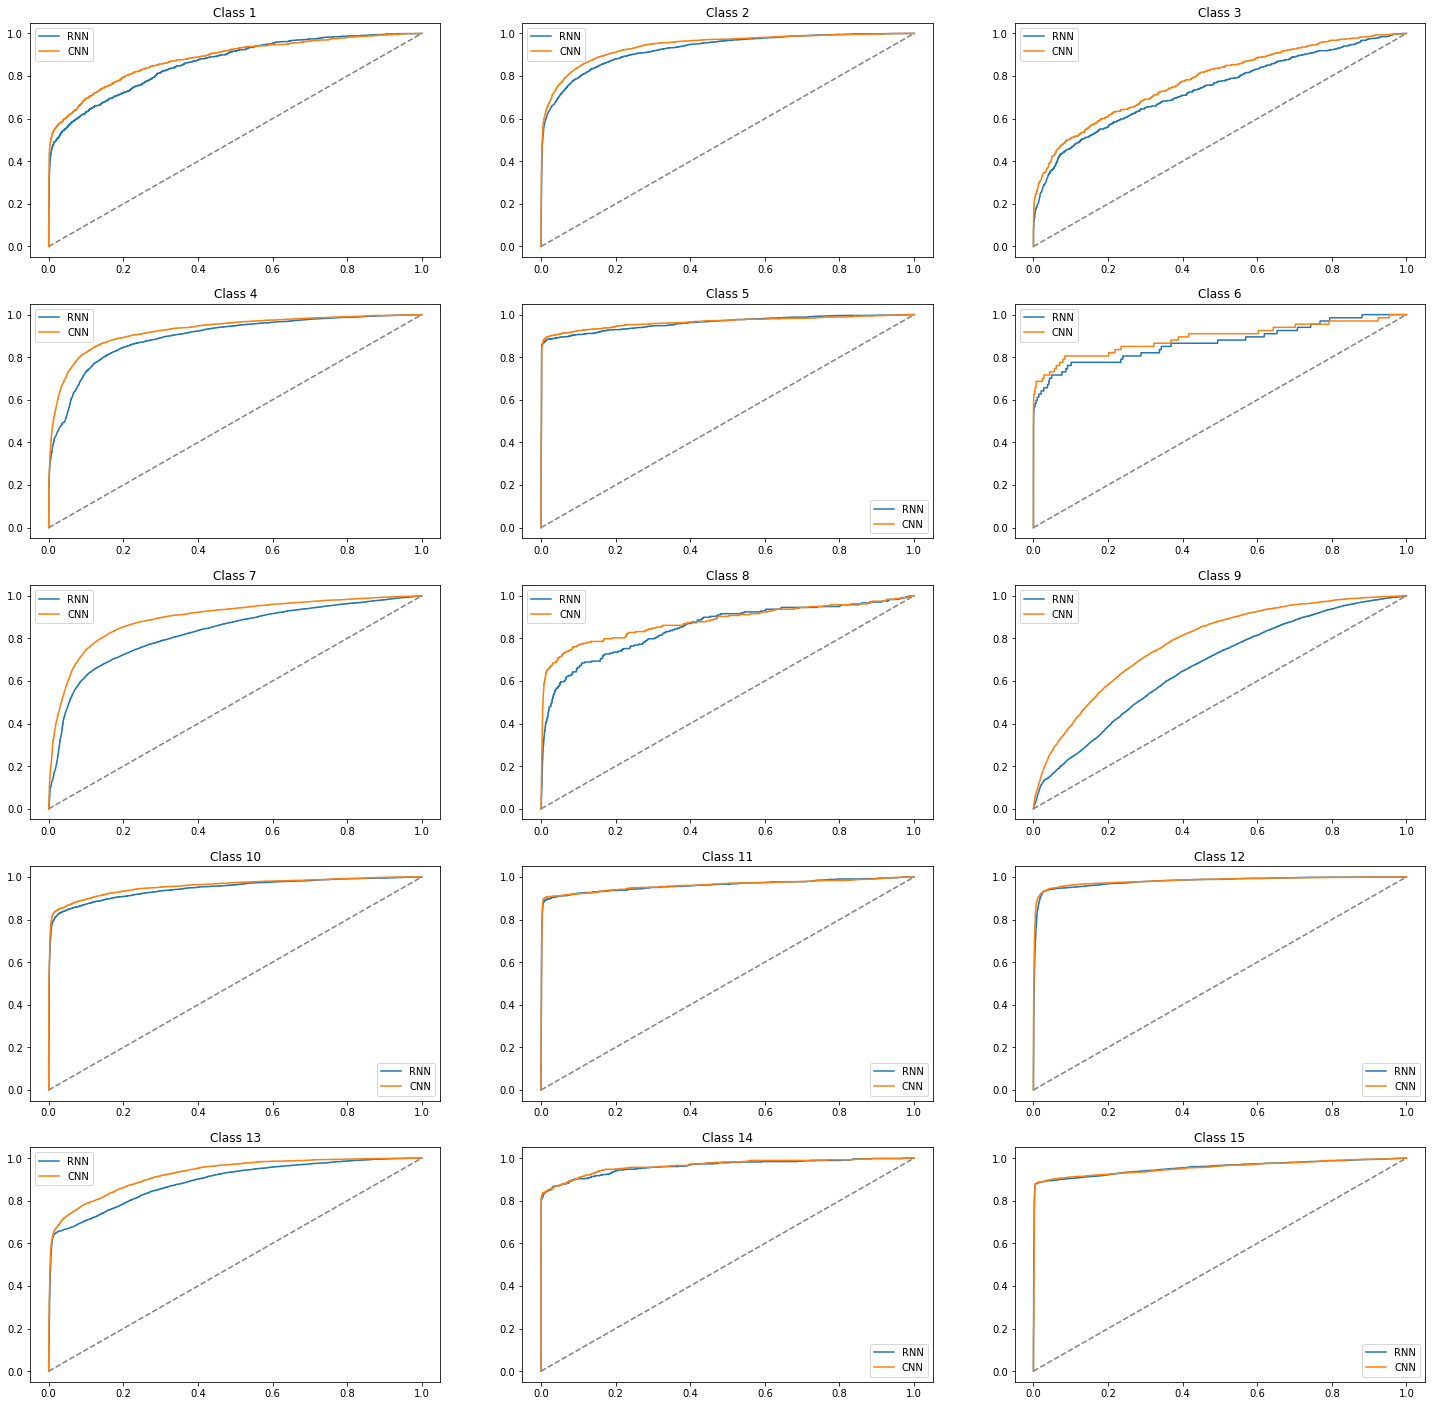

In [242]:
fig, axs = plt.subplots(5, 3, figsize=(25,25))

for i in tqdm(range(15)):
    fpr_rnn, tpr_rnn, _ = roc_curve(Y_test.values[:,i]>0, pred_text_RNN[:,i])
    fpr_cnn, tpr_cnn, _ = roc_curve(Y_test.values[:,i]>0, pred_text_CNN[:,i])
    
    axs_r = floor(i/3)
    axs_c = i - 3*floor(i/3)

    axs[axs_r, axs_c].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[axs_r, axs_c].plot(fpr_rnn, tpr_rnn, linestyle='-', label='RNN')
    axs[axs_r, axs_c].plot(fpr_cnn, tpr_cnn, linestyle='-', label='CNN')
    
    axs[axs_r, axs_c].set_title('Class %i' % (i+1))
    axs[axs_r, axs_c].legend()


Overall, CNN is performing better than RNN in this dataset. For most of the classes, CNN has higher AUC score compared to RNN.

### Reference

1. Autoencoder (CNN):  Chollet, Francois. “The Keras Blog.” The Keras Blog ATOM, https://blog.keras.io/building-autoencoders-in-keras.html.

2. ImageClassification (transfer learning): “Python Keras.applications.ResNet50() Examples.” Program Creek, https://www.programcreek.com/python/example/93644/keras.applications.ResNet50.

3. TextClassification (RNN): “Text Classification with an RNN  :   TensorFlow Core.” TensorFlow, https://www.tensorflow.org/tutorials/text/text_classification_rnn.

4. TextClassification (CNN): Agarwal, Rahul. “NLP Learning Series: Part 3 - Attention, CNN and What Not for Text Classification.” Medium, Towards Data Science, 21 July 2019, https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566.